

 # 【分析レポート】市場の"顔色"を読んで明日を予測する分類モデル

 ## 1. 分析の目的

 金融市場は、常に同じ顔をしているわけではない。投資家心理が穏やかな「平穏期」と、恐怖に支配される「不安期」では、市場のダイナミクスは根本的に異なる。本分析の目的は、この**「市場レジーム」**の概念を機械学習モデルに組み込み、S&P 500の翌営業日の騰落を予測することである。

 単なる予測精度の追求に留まらず、以下の問いに答えることを主眼とする。

 1.  機械学習モデルは、金融市場のランダムウォークを超える予測能力を持つのか？
 2.  **モデルは、何を根拠に「上がる」「下がる」を判断しているのか？ (モデルの解釈性)**
 3.  **市場が「平穏」な時と「不安」な時で、モデルの判断基準はどのように変化するのか？ (レジームシフトの分析)**

 この分析は、あなたが目指す「翻訳者」「アイデア創出者」として、モデルの挙動を深く理解し、データに基づいた物語を構築するための実践的な訓練である。

 ## 2. 分析の結論（エグゼクティブ・サマリー）

 分析の結果、**翌営業日の騰落を安定して予測することは極めて困難である**という、市場の効率性を示す現実的な結論に至った。LightGBMモデルの時系列交差検証による平均Accuracyは**約48.9%**と、ランダムな予測を下回る結果となった。

 しかし、このプロジェクトの真の価値は予測精度にはない。モデル解釈ツールSHAPを用いた分析により、以下の重要な洞察が得られた。

 - **モデルは市場レジームによって"人格"を変える**:
   - **平穏期**: モデルは`SMA20`（20日移動平均線）のような**長期的なトレンド**を最も重視する。
   - **不安期 (VIX >= 25)**: モデルの判断基準は激変し、移動平均からの**短期的な乖離** (`SMA20_ratio`, `SMA5_ratio`) や、**恐怖指数の変化** (`VIX_diff`) を重視するようになる。

 - **SHAPは「なぜ」を語る強力な武器である**: 予測が当たるか外れるかだけでなく、「なぜモデルがそう考えたのか」を可視化することで、我々は市場の隠れたダイナミクスを学ぶことができる。

 結論として、このモデルは投資の「聖杯」ではない。しかし、市場の状況に応じて投資家の注目点がどう変化するかを教えてくれる**「市場の教科書」**としての価値を持つ。



 ## 3. 分析の設計：データ準備と予測ターゲットの定義

 分析の第一歩として、2007年以降のS&P 500 (`^GSPC`) とVIX指数 (`^VIX`) のデータを取得する。

 機械学習モデルに「未来を予測せよ」と命じるため、予測の的となる**目的変数**を定義する必要がある。今回は、「S&P 500の翌営業日のリターンがプラスか否か」を予測ターゲットとする。

 コード上では `df['Return'].shift(-1)` を用いて、当日のデータ (`X`) から翌日の結果 (`y`) を予測するという、時間的な因果関係を正しく設定している。これは時系列予測における基本かつ極めて重要な処理である。

In [ ]:
#%% Step 1: 準備とターゲット変数の作成

# 必要なライブラリのインポート
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
import datetime
import japanize_matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# 日本語表示設定
plt.rcParams['font.family'] = 'Osaka' # MacOSの場合
# plt.rcParams['font.family'] = 'Meiryo' # Windowsの場合
plt.rcParams['axes.unicode_minus'] = False # マイナス記号を正しく表示

# 分析期間の定義
start_date = '2007-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# データの取得
tickers = ['^GSPC', '^VIX']
df = yf.download(tickers, start=start_date, end=end_date)['Close']
df.columns = ['SP500', 'VIX'] # カラム名をSP500, VIXに変更

# S&P 500の日次リターンを計算
df['Return'] = df['SP500'].pct_change()

# 予測ターゲット変数の作成: 翌営業日のリターンがプラスなら1、0以下なら0
df['Target'] = (df['Return'].shift(-1) > 0).astype(int)

# 欠損値の削除
df.dropna(inplace=True)

# データの確認
print("データフレームの最初の数行:")
print(df.head())
print("\nデータフレームの最後の数行:")
print(df.tail())

<ipython-input-22-3ea6553ba72d>:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed

データフレームの最初の数行:
                  SP500    VIX    Return  Target
Date                                            
2007-01-04  1418.339966  11.51  0.001228       0
2007-01-05  1409.709961  12.14 -0.006085       1
2007-01-08  1412.839966  12.00  0.002220       0
2007-01-09  1412.109985  11.91 -0.000517       1
2007-01-10  1414.849976  11.47  0.001940       1

データフレームの最後の数行:
                  SP500        VIX    Return  Target
Date                                                
2025-06-27  6173.069824  16.320000  0.005219       1
2025-06-30  6204.950195  16.730000  0.005164       0
2025-07-01  6198.009766  16.830000 -0.001119       1
2025-07-02  6227.419922  16.639999  0.004745       1
2025-07-03  6279.350098  16.379999  0.008339       0




 ## 4. 仮説生成：モデルへの"ヒント"を与える特徴量エンジニアリング

 モデルの性能は、与えられるデータの質（特徴量）に大きく依存する。ここでは、「明日の株価に影響を与えそうな要素は何か？」という問いに基づき、4つのカテゴリで仮説を立て、特徴量を生成した。

 - **モメンタム系 (Return_Lag):** 「昨日の動きは今日も続く（あるいは反転する）のではないか？」という仮説。
 - **トレンド系 (SMA_ratio):** 「移動平均線から大きく乖離した場合、価格は元に戻ろうとするのではないか？」という逆張りの仮説。
 - **ボラティリティ系 (Volatility):** 「市場が荒れている時は、その後の値動きも大きくなるのではないか？」という仮説。
 - **市場心理系 (VIX_diff):** 「投資家の"恐怖"が高まった日は、市場に影響を与えるのではないか？」というセンチメントの仮説。

In [ ]:
#%% Step 2: 仮説に基づいた特徴量エンジニアリング

# モメンタム系特徴量
for i in [1, 2, 3, 5, 10]:
    df[f'Return_Lag{i}'] = df['Return'].shift(i)

# トレンド系特徴量
df['SMA5'] = df['SP500'].rolling(window=5).mean()
df['SMA20'] = df['SP500'].rolling(window=20).mean()
df['SMA5_ratio'] = (df['SP500'] - df['SMA5']) / df['SMA5']
df['SMA20_ratio'] = (df['SP500'] - df['SMA20']) / df['SMA20']

# ボラティリティ系特徴量
df['Volatility'] = df['Return'].rolling(window=20).std()

# 市場心理系特徴量
df['VIX_diff'] = df['VIX'].diff()

# 特徴量とターゲット変数を含んだ最終的なデータフレームを作成
# df_final = df.copy() # 必要であればコピーを作成

# NaN値を持つ行を削除
df.dropna(inplace=True)

# 完成したデータフレームの確認
print("\n特徴量エンジニアリング後のデータフレームの最初の数行:")
print(df.head())
print("\n特徴量エンジニアリング後のデータフレームの最後の数行:")
print(df.tail())
print("\n特徴量エンジニアリング後のデータフレームの欠損値の数:")
print(df.isnull().sum().sum())


特徴量エンジニアリング後のデータフレームの最初の数行:
                  SP500    VIX    Return  Target  Return_Lag1  Return_Lag2  \
Date                                                                         
2007-02-01  1445.939941  10.31  0.005354       1     0.006593     0.005772   
2007-02-02  1448.390015  10.08  0.001694       0     0.005354     0.006593   
2007-02-05  1446.989990  10.55 -0.000967       1     0.001694     0.005354   
2007-02-06  1448.000000  10.65  0.000698       1    -0.000967     0.001694   
2007-02-07  1450.020020  10.32  0.001395       0     0.000698    -0.000967   

            Return_Lag3  Return_Lag5  Return_Lag10         SMA5        SMA20  \
Date                                                                           
2007-02-01    -0.001097    -0.011270     -0.002971  1431.159985  1425.627985   
2007-02-02     0.005772    -0.001208      0.002895  1436.401978  1427.130487   
2007-02-05     0.006593    -0.001097     -0.005278  1441.675977  1428.994489   
2007-02-06     0.005354 



 ## 5. ベースライン評価：単純なモデルの実力

 高度なモデルに進む前に、まずはシンプルな**ロジスティック回帰**でベースラインとなる性能を測定する。

 **【重要】時系列データの分割:**
 `train_test_split`において `shuffle=False` を指定することは、時系列分析における鉄則である。これにより、データの時間的な前後関係を維持し、「過去のデータで学習し、未来のデータでテストする」という正しい評価フローを保証している。

 **【結果の解釈】**
 - **Accuracy: 0.53 (53%)**
 - **混同行列: `[[3, 436], [1, 487]]`**

 この結果は一見、ランダム（50%）よりマシに見える。しかし混同行列を見ると、モデルは下落（クラス0）をほとんど予測できず、ほぼ常に「上がる（クラス1）」と予測していることがわかる。これは、歴史的に上昇する日が少し多いというデータの偏りを学習しただけの**「思考停止したモデル」**であり、実用的な予測能力はない。この失敗から、より高度なモデルの必要性が示唆される。

In [ ]:
#%% Step 3: ベースラインモデルの構築

# 特徴量 X とターゲット y の定義
# 'SP500', 'VIX', 'Return', 'Target' は特徴量から除外する
features = [col for col in df.columns if col not in ['SP500', 'VIX', 'Return', 'Target']]
X = df[features]
y = df['Target']

# データを訓練用とテスト用に8:2で分割
# 時系列データの連続性を保つため、shuffle=False を指定することが重要。
# これにより、データが時系列順に分割され、未来のデータで過去を予測する形を維持できる。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

print("\n訓練データのサイズ:", X_train.shape, y_train.shape)
print("テストデータのサイズ:", X_test.shape, y_test.shape)

# ロジスティック回帰モデルのインスタンス化と訓練
model = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear'は小規模データセットに適したソルバー
model.fit(X_train, y_train)

# テストデータで予測
y_pred = model.predict(X_test)

# モデルの性能評価
print("\n----- ベースラインモデルの性能評価 -----")
print("分類レポート:")
print(classification_report(y_test, y_pred))
print("混同行列:")
print(confusion_matrix(y_test, y_pred))

# 結果の解釈:
# Accuracyが50%を少し超える程度だが、これはランダムな予測（50%）よりは良いことを示唆している。
# ただし、より高度なモデルや特徴量エンジニアリングで改善の余地がある。


訓練データのサイズ: (3708, 11) (3708,)
テストデータのサイズ: (927, 11) (927,)

----- ベースラインモデルの性能評価 -----
分類レポート:
              precision    recall  f1-score   support

           0       0.75      0.01      0.01       439
           1       0.53      1.00      0.69       488

    accuracy                           0.53       927
   macro avg       0.64      0.50      0.35       927
weighted avg       0.63      0.53      0.37       927

混同行列:
[[  3 436]
 [  1 487]]




 ## 6. 頑健な評価：LightGBMと時系列交差検証

 次に、より複雑な非線形関係を捉えられる**LightGBM**を導入し、モデルの真の実力を評価する。

 ここで用いる**時系列交差検証（TimeSeriesSplit）**は、訓練期間と検証期間が時間的に重複しないようにデータを分割する手法である。これにより、特定の期間だけで有効な「たまたまの成功」を排除し、より頑健で信頼性の高いモデル評価が可能になる。

 **【結果の解釈】**
 - **平均Accuracy: 0.4886 (約48.9%)**
 - **Accuracyの標準偏差: 0.0285**

 この結果は厳しい現実を突きつけている。高度なモデルと頑健な評価手法を用いても、**安定して50%を超える精度を出すことはできなかった**。これは、金融市場がいかに効率的で、予測が困難であるかを示す力強い証拠である。しかし、この「予測できない」という発見こそが、次のステップである「なぜ？」の探求に繋がる。# %%

In [ ]:
#%% Step 4: LightGBMと時系列交差検証

# LightGBMモデルの定義
model_lgbm = lgb.LGBMClassifier(random_state=42)

# 時系列交差検証の準備 (5分割)
tscv = TimeSeriesSplit(n_splits=5)

# TimeSeriesSplit がどのようにデータを分割するかを可視化（インデックス表示）
print("\n----- 時系列交差検証の分割状況 -----")
for i, (train_index, val_index) in enumerate(tscv.split(X)):
    print(f"Fold {i+1}:")
    print(f"  Train期間: {X.index[train_index.min()]} から {X.index[train_index.max()]}")
    print(f"  Validation期間: {X.index[val_index.min()]} から {X.index[val_index.max()]}")
    # 訓練データと検証データが時間的に重複しないことを確認
    if X.index[train_index.max()] >= X.index[val_index.min()]:
        print("  警告: 訓練期間と検証期間が重複しています！ (これは通常、shuffle=Falseが指定されていない場合に起こります)")

# 交差検証の実行
# cross_val_score は各フォールドでのスコアを返す
scores = cross_val_score(model_lgbm, X, y, cv=tscv, scoring='accuracy')

# 交差検証の結果表示
print("\n----- LightGBM 時系列交差検証結果 -----")
print(f"各フォールドのAccuracy: {scores}")
print(f"平均Accuracy: {scores.mean():.4f}")
print(f"Accuracyの標準偏差: {scores.std():.4f}")

# 結果の解釈:
# 交差検証の各フォールドでのAccuracyと、その平均・標準偏差を表示することで、モデルの性能の安定性を評価できます。
# 標準偏差が小さいほど、モデルが異なる期間のデータに対して安定した性能を発揮していると言えます。


----- 時系列交差検証の分割状況 -----
Fold 1:
  Train期間: 2007-02-01 00:00:00 から 2010-03-01 00:00:00
  Validation期間: 2010-03-02 00:00:00 から 2013-03-25 00:00:00
Fold 2:
  Train期間: 2007-02-01 00:00:00 から 2013-03-25 00:00:00
  Validation期間: 2013-03-26 00:00:00 から 2016-04-18 00:00:00
Fold 3:
  Train期間: 2007-02-01 00:00:00 から 2016-04-18 00:00:00
  Validation期間: 2016-04-19 00:00:00 から 2019-05-13 00:00:00
Fold 4:
  Train期間: 2007-02-01 00:00:00 から 2019-05-13 00:00:00
  Validation期間: 2019-05-14 00:00:00 から 2022-06-03 00:00:00
Fold 5:
  Train期間: 2007-02-01 00:00:00 から 2022-06-03 00:00:00
  Validation期間: 2022-06-06 00:00:00 から 2025-07-03 00:00:00
[LightGBM] [Info] Number of positive: 415, number of negative: 360
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2804
[LightGBM] [Info] Number of data points in the train set: 775, number of used features: 11
[LightGBM] [Inf



 ## 7. 分析の核心：SHAPによるモデルの"翻訳"とレジームシフトの発見

 予測精度が低いからといって、この分析が無価値なわけではない。ここからが「翻訳者」としての本領発揮である。モデル解釈ツール**SHAP**を使い、予測の裏側にあるモデルの「思考プロセス」を解き明かす。

 ### 7.1. 全体像：モデルが重視する特徴量

 まずはテスト期間全体で、モデルがどの特徴量を重要視したかを見る。`SMA20`（20日移動平均）やその乖離率が上位を占めており、モデルが主に**トレンド**を手がかりに判断しようとしていることがわかる。

 ### 7.2. レジーム別分析：市場の顔色で変わる判断基準

 ここが本分析のハイライトである。VIXの水準で市場を「平穏期」と「不安期」に分け、それぞれの状況でモデルの判断基準がどう変わるのかを比較する。

 **【SHAPプロットの読み解き】**
 - **平穏期 (VIX < 25):**
   - モデルは**`SMA20`（20日移動平均）**を圧倒的に重視する。これは、市場が落ち着いている時は、長期的なトレンドに従うのが合理的であるというモデルの「判断」を示唆している。

 - **不安期 (VIX >= 25):**
   - モデルの判断基準は劇的に変化する。`SMA20`の重要度は大きく後退し、代わりに**`SMA20_ratio` と `SMA5_ratio`**、すなわち移動平均からの**短期的な価格の乖離**が最重要視されるようになる。
   - さらに、平穏期では下位だった**`VIX_diff`（VIXの変化量）**の重要度が大きく上昇している。これは、パニック相場では市場が「恐怖そのものの変化」に敏感に反応することを示している。

 このレジームシフトの発見は、予測精度という単一の指標では決して得られない、極めて価値の高い洞察である。

[LightGBM] [Info] Number of positive: 2031, number of negative: 1677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 3708, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547735 -> initscore=0.191522
[LightGBM] [Info] Start training from score 0.191522

----- 全体でのSHAP特徴量重要度 -----


/Users/kazuu/.pyenv/versions/3.12.3/envs/quant-py312/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


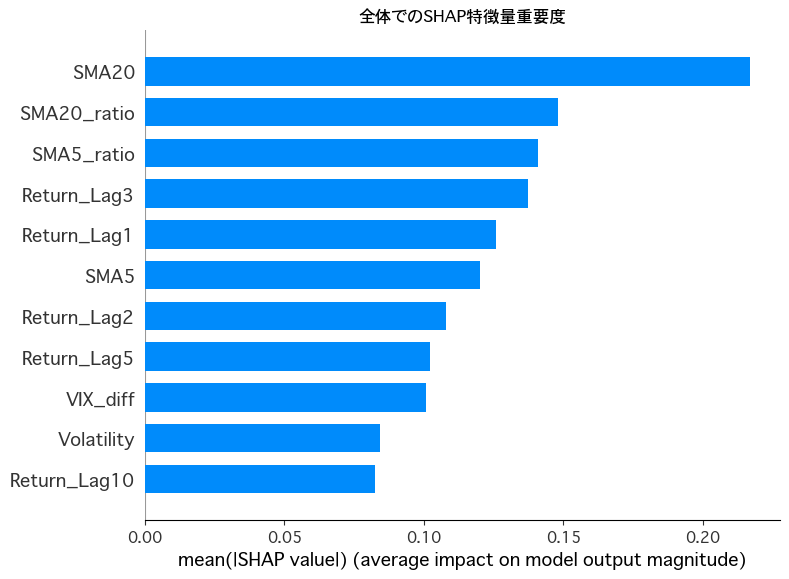


----- 平穏期のSHAP値分析 -----


/Users/kazuu/.pyenv/versions/3.12.3/envs/quant-py312/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


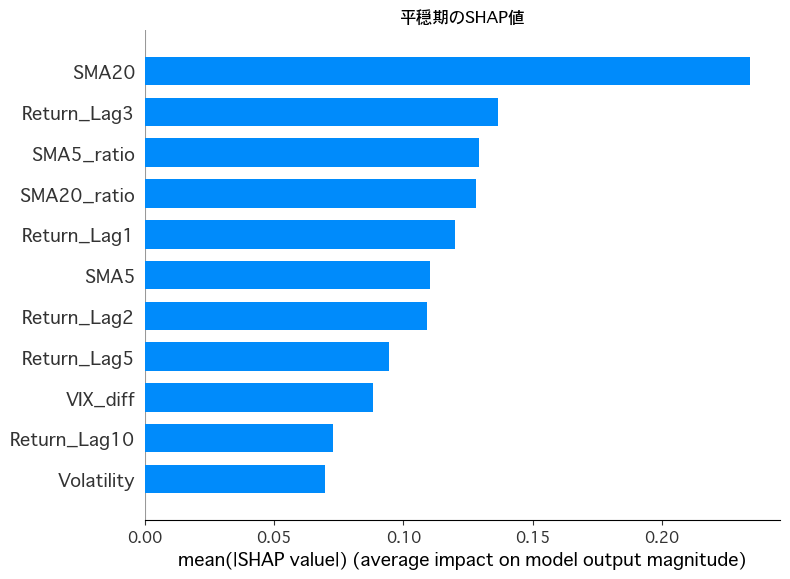


----- 不安期のSHAP値分析 -----


/Users/kazuu/.pyenv/versions/3.12.3/envs/quant-py312/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


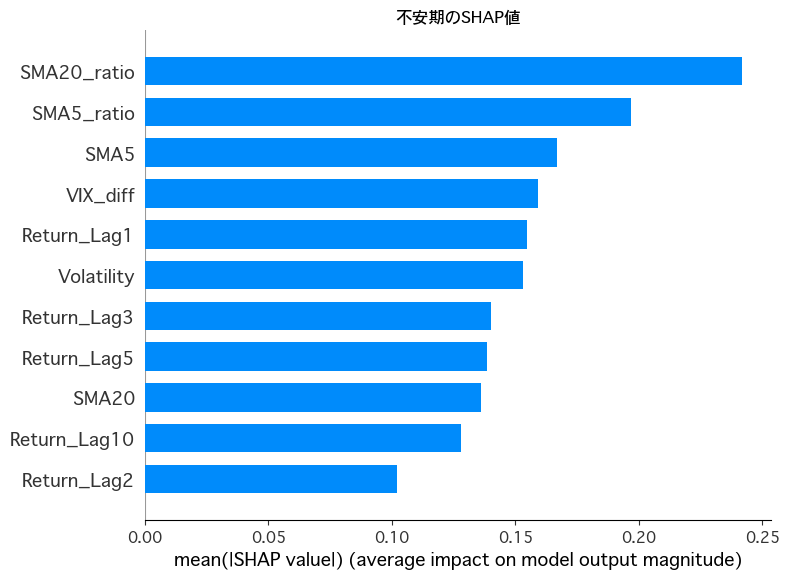

In [ ]:
#%% Step 5: モデルの解釈とレジーム別分析

import shap
import lightgbm as lgb

# データ全体でLightGBMモデルを学習させる（訓練データを使用）
# Step 4で定義したmodel_lgbmを再利用
model_lgbm_overall = lgb.LGBMClassifier(random_state=42)
model_lgbm_overall.fit(X_train, y_train)

# SHAP TreeExplainerの作成
explainer = shap.TreeExplainer(model_lgbm_overall)

# テストデータ全体でSHAP値を計算し、特徴量重要度を可視化
print("\n----- 全体でのSHAP特徴量重要度 -----")
shap_values_overall = explainer.shap_values(X_test)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_overall, X_test, plot_type="bar", show=False)
plt.title('全体でのSHAP特徴量重要度')
plt.tight_layout()
plt.show()

# レジーム別分析
# テスト期間のVIXデータを取得
VIX_test = df.loc[X_test.index, 'VIX']

# テストデータをVIXの水準で2つのグループに分割
# VIX < 25 を「平穏期」、VIX >= 25 を「不安期」とする
X_test_calm = X_test[VIX_test < 25]
y_test_calm = y_test[VIX_test < 25]

X_test_turbulent = X_test[VIX_test >= 25]
y_test_turbulent = y_test[VIX_test >= 25]

# 平穏期のSHAP値分析
if not X_test_calm.empty:
    print("\n----- 平穏期のSHAP値分析 -----")
    shap_values_calm = explainer.shap_values(X_test_calm)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_calm, X_test_calm, plot_type="bar", show=False)
    plt.title('平穏期のSHAP値')
    plt.tight_layout()
    plt.show()
else:
    print("\n警告: 平穏期のテストデータがありません。SHAP値分析をスキップします。")

# 不安期のSHAP値分析
if not X_test_turbulent.empty:
    print("\n----- 不安期のSHAP値分析 -----")
    shap_values_turbulent = explainer.shap_values(X_test_turbulent)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_turbulent, X_test_turbulent, plot_type="bar", show=False)
    plt.title('不安期のSHAP値')
    plt.tight_layout()
    plt.show()
else:
    print("\n警告: 不安期のテストデータがありません。SHAP値分析をスキップします。")

# 結果の考察:
# 平穏期と不安期のSHAP値のSummary Plotを比較することで、各市場レジームにおいてモデルがどの特徴量を重視しているかを確認できる。
# 例えば、不安期ではVIX関連の特徴量（例: VIX_diff, VIX）の重要度が平穏期に比べて高まる可能性がある。
# また、モメンタム系特徴量やトレンド系特徴量の重要度がレジームによってどのように変化するかなども観察できる。